In [1]:
#x01_populationStatistics

In [2]:
from chewc.callback import *
from chewc.policy import *
from chewc.sim import *
from chewc.lab import *
from chewc.config import *

In [3]:
import matplotlib.pyplot as plt
import uuid
import pdb
import torch
from matplotlib.animation import FuncAnimation
import torch
import torch.optim as optim
import torch.nn.functional as F
import torch.nn as nn
import gymnasium as gym
import numpy as np
device='cpu'
from torch.utils.tensorboard import SummaryWriter



import gymnasium as gym
from stable_baselines3 import PPO
from stable_baselines3.common.vec_env import DummyVecEnv
from stable_baselines3.common.callbacks import CallbackList


In [4]:
#| export

import gymnasium as gym
from stable_baselines3 import PPO
from stable_baselines3.common.vec_env import DummyVecEnv
import numpy as np
from chewc.sim import *
import torch

class SelectionIntensityEnvironment(gym.Env):
    def __init__(self, SP, config):
        super(SelectionIntensityEnvironment, self).__init__()
        self.SP = SP
        self.config = config  # Store the config
        self.current_generation = 0
        self.max_generations = SP.max_generations
        # Get action space bounds from config, with defaults if not provided
        
        self.action_low = config.get('action_low', 0.01)
        self.action_high = config.get('action_high', 0.99)
        
        self.action_space = gym.spaces.Box(
            low=np.array([self.action_low]), 
            high=np.array([self.action_high]), 
            dtype=np.float32
        )
        
        # Update observation space based on config
#         obs_config = config['observation_config']['remaining_proportion']
        self.observation_config = config['observation_config']
        # Dynamically create observation space
        obs_low = []
        obs_high = []
        self.obs_keys = []
        for key, value in self.observation_config.items():
            self.obs_keys.append(key)
            obs_low.append(value['low'])
            obs_high.append(value['high'])
        
        self.observation_space = gym.spaces.Box(
            low=np.array(obs_low, dtype=np.float32),
            high=np.array(obs_high, dtype=np.float32)
        )

        self.action_values = []
        self.genetic_variance = []
        self.max_breeding_values = []
        self.final_generations = []
        self.episode_count = 0
        self.rewards = []
        self.episode_reward = 0
        
        #config
        self.config =config
        
    def _get_obs(self):
        obs = []
        for key in self.obs_keys:
            if key == 'remaining_proportion':
                obs.append(1 - (self.current_generation / self.max_generations))
            elif key == 'genetic_variance':
                obs.append(self.population.breeding_values.var().cpu().item())
            elif key == 'mean_phenotype':
                obs.append(self.population.phenotypes.mean().cpu().item())
            elif key == 'max_breeding_value':
                obs.append(self.population.breeding_values.max().cpu().item())
            # Add more elif statements for other possible inputs
        return np.array(obs, dtype=np.float32)


    def _get_info(self):
        return {
            "max_phenotype": self.population.breeding_values.max().cpu().item(),
            "genetic_variance": self.population.breeding_values.var().cpu().item(),
            "current_generation": self.current_generation
        }

    def reset(self, seed=None, options=None):
        super().reset(seed=seed)
        self.population = self.SP.founder_pop
        self.phenotype = phenotype(self.population, self.SP.T, self.SP.h2)
        self.current_generation = 0
        self.episode_reward = 0
        observation = self._get_obs()
        info = self._get_info()
        
        return observation, info

    def step(self, action):
        
        # Map the action from [-1, 1] to [action_low, action_high]
#         print('raw', action)
#         action = scale_values(action, to_range=(self.action_low, self.action_high))
#         print('usu', action)
        total_selected = max((2,int(action * self.population.size)))
        selected = torch.topk(self.population.phenotypes, total_selected).indices
        self.population = create_pop(self.SP.G, random_crosses(self.population.haplotypes[selected], self.SP.pop_size))
        self.phenotype = phenotype(self.population, self.SP.T, self.SP.h2)
        self.current_generation += 1

        observation = self._get_obs()
        info = self._get_info()
        info['normalized_action'] = action
        
        terminated = self.current_generation > self.SP.max_generations
        #REWARD
        if self.config.get('sparse_reward', False):  # Use .get() with a default value
            reward = 0 if not terminated else float(self.population.breeding_values.max())
        else:
            reward = float(self.population.breeding_values.max())
        self.episode_reward += reward

        if terminated:
            info['final_generation'] = {
            "max_phenotype": self.population.breeding_values.max().cpu().item(),
            "genetic_variance": self.population.breeding_values.var().cpu().item(),
            "current_generation": self.current_generation
            }

        return observation, reward, bool(terminated), False, info

import torch as th
import torch.nn as nn
from stable_baselines3.common.torch_layers import BaseFeaturesExtractor
from stable_baselines3.common.policies import ActorCriticPolicy

class CustomFeatureExtractor(BaseFeaturesExtractor):
    def __init__(self, observation_space: gym.spaces.Box, features_dim: int = 64):
        super(CustomFeatureExtractor, self).__init__(observation_space, features_dim)
        
        # For now, a simple linear layer for the scalar input
        self.linear = nn.Sequential(
            nn.Linear(observation_space.shape[0], features_dim),
            nn.ReLU()
        )

    def forward(self, observations: th.Tensor) -> th.Tensor:
        return self.linear(observations)

class CustomPolicy(ActorCriticPolicy):
    def __init__(self, *args, **kwargs):
        super(CustomPolicy, self).__init__(
            *args,
            **kwargs,
            features_extractor_class=CustomFeatureExtractor,
            features_extractor_kwargs=dict(features_dim=64)
        )

In [5]:

def create_simulation(config=None):
    if config is None:
        config = get_default_config()
    
    seed = config['seed']
    set_seed(seed)
    
    G = Genome(config['n_chr'], config['n_loci'], seed=seed)
    
    founder_haplotypes = np.load('../nbs/data/g2f_ch10.npy')
    random_parent_indices = np.random.choice(founder_haplotypes.shape[0], config['n_parents'], replace=False)
    random_loci_indices = np.random.choice(founder_haplotypes.shape[2], config['n_loci'], replace=False)
    
    founder_haplotypes = founder_haplotypes[random_parent_indices,:,:]
    founder_haplotypes = founder_haplotypes[:,:,random_loci_indices]
    founder_haplotypes = torch.tensor(founder_haplotypes).unsqueeze(2)
    
    inbred_founders = create_pop(G, founder_haplotypes)
    f1 = create_pop(G, random_crosses(inbred_founders.haplotypes, 1000))
    founder_pop = create_pop(G, random_crosses(f1.haplotypes, config['pop_size']))
    
    T = Trait(G, founder_pop, target_mean=config['target_mean'], target_variance=config['target_variance'], seed=seed)
    
    SP = SimParams(founder_pop, config)
    env = SelectionIntensityEnvironment(SP, config)
    
    return env




In [6]:
import numpy as np
import matplotlib.pyplot as plt
def collect_baselines(env, actions, repetitions=10, cycles=5):
    results = {action: {'max_phenotype': [], 'gv': []} for action in actions}
    final_gen_averages = {}
    env.reset()
    for action in actions:
        final_gen_phenotypes = []
        for _ in range(repetitions):
            env.reset()
            cycle_max_phenotype = []
            cycle_gv = []
            cycle_max_phenotype.append(env.population.breeding_values.max())
            cycle_gv.append(env.population.breeding_values.var())
            for _ in range(cycles):
                env.step(np.array([action]))
                max_phenotype = env.population.breeding_values.max()
                gv = env.population.breeding_values.var()
                cycle_max_phenotype.append(max_phenotype)
                cycle_gv.append(gv)
            
            results[action]['max_phenotype'].append(cycle_max_phenotype)
            results[action]['gv'].append(cycle_gv)
            final_gen_phenotypes.append(cycle_max_phenotype[-1])
        
        final_gen_averages[action] = np.mean(final_gen_phenotypes)
    
    best_action = max(final_gen_averages, key=final_gen_averages.get)
    best_average = final_gen_averages[best_action]
    
    return results, best_action, best_average
def plot_best_run(results, best_action):
    plt.figure(figsize=(12, 10))
    
    max_phenotypes = np.array(results[best_action]['max_phenotype'])
    genetic_variances = np.array(results[best_action]['gv'])
    
    mean_phenotypes = np.mean(max_phenotypes, axis=0)
    std_phenotypes = np.std(max_phenotypes, axis=0)
    mean_gv = np.mean(genetic_variances, axis=0)
    std_gv = np.std(genetic_variances, axis=0)
    
    cycles = range(len(mean_phenotypes))
    best_action_translated = scale_values(best_action)
    
    # Plot Max Phenotype
    plt.subplot(2, 1, 1)
    plt.plot(cycles, mean_phenotypes, label=f'Action {best_action_translated:.3f}')
    plt.fill_between(cycles, mean_phenotypes - std_phenotypes, mean_phenotypes + std_phenotypes, alpha=0.3)
    plt.xlabel('Cycle')
    plt.ylabel('Max Phenotype')
    plt.title(f'Max Phenotype over Cycles for Best Action')
    plt.legend()
    plt.grid(True)
    
    # Plot Genetic Variance
    plt.subplot(2, 1, 2)
    plt.plot(cycles, mean_gv, label=f'Action {best_action:.3f}')
    plt.fill_between(cycles, mean_gv - std_gv, mean_gv + std_gv, alpha=0.3)
    plt.xlabel('Cycle')
    plt.ylabel('Genetic Variance')
    plt.title(f'Genetic Variance over Cycles for Best Action')
    plt.legend()
    plt.grid(True)
    
    plt.tight_layout()
    plt.show()


NameError: name 'env' is not defined

observation_config : {'remaining_proportion': {'type': 'scalar', 'low': 0, 'high': 1}, 'genetic_variance': {'type': 'scalar', 'low': 0, 'high': inf}, 'mean_phenotype': {'type': 'scalar', 'low': -inf, 'high': inf}, 'max_breeding_value': {'type': 'scalar', 'low': -inf, 'high': inf}}
action_low : 0.01
action_high : 0.99
sparse_reward : True
n_parents : 5
n_chr : 1
n_loci : 100
pop_size : 100
max_generations : 3
h2 : 0.5
target_mean : 0
target_variance : 1
reps : 1
total_timesteps : 500000
learning_rate : 0.0003
gae_lambda : 0.95
log_freq : 100
start_gen : 10
end_gen : 100
start_gae_lambda : 0.9
end_gae_lambda : 0.95
seed : 4


/tmp/ipykernel_683637/2369790591.py:95: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  total_selected = max((2,int(action * self.population.size)))


Best action: 0.110
Best average max phenotype in final generation: 8.360


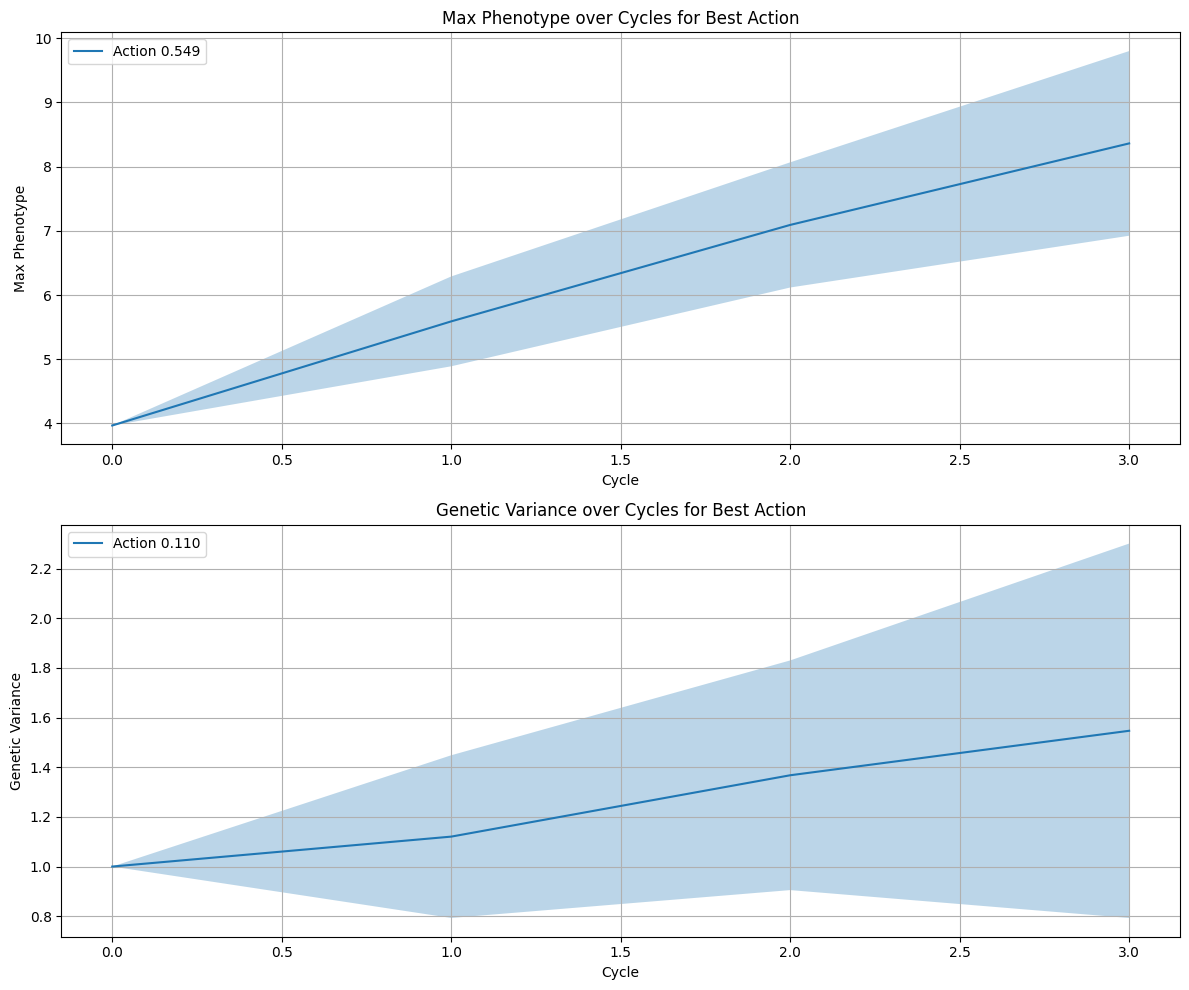

In [22]:
config = get_default_config()
config['n_parents'] = 5
config['n_loci'] = 100
config['pop_size'] = 100
config['max_generations'] = 3
config['total_timesteps'] = 500000
config['seed'] = 4
config['sparse_reward'] = True
config['h2'] = .5

for i in config:
    print(f"{i} : {config[i]}")
env = create_simulation(config)
env.reset()

    
# Usage remains the same
actions = np.linspace(.01, .35, 35)  # or however many actions you want to test
results, best_action, best_average = collect_baselines(env, actions, repetitions=10, cycles=env.SP.max_generations)

print(f"Best action: {best_action:.3f}")
print(f"Best average max phenotype in final generation: {best_average:.3f}")

# Plot the best run with both max phenotype and genetic variance
plot_best_run(results, best_action)

In [23]:
FE = CustomFeatureExtractor(env.observation_space)
mock_observation = th.tensor([[0.5,0.5,0.5,0.5,]], dtype=th.float32)  # Single scalar input
FE(mock_observation)

tensor([[0.0000e+00, 0.0000e+00, 3.1431e-01, 2.3282e-02, 8.3666e-01, 0.0000e+00,
         1.1509e-01, 0.0000e+00, 8.4538e-01, 0.0000e+00, 2.1092e-01, 0.0000e+00,
         2.8072e-01, 3.6931e-01, 0.0000e+00, 1.1429e-04, 6.4033e-01, 2.6400e-01,
         0.0000e+00, 0.0000e+00, 2.7315e-01, 1.4678e-01, 1.2289e-01, 0.0000e+00,
         0.0000e+00, 6.3131e-01, 4.6990e-01, 6.0659e-02, 2.9561e-01, 0.0000e+00,
         3.5166e-01, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         7.8002e-01, 0.0000e+00, 0.0000e+00, 3.7629e-01, 2.2206e-01, 8.9200e-01,
         1.2121e-01, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 1.5848e-01, 4.0388e-01, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         2.5923e-01, 1.2019e-01, 1.9968e-01, 0.0000e+00, 0.0000e+00, 5.2709e-01,
         0.0000e+00, 0.0000e+00, 9.6696e-01, 0.0000e+00]],
       grad_fn=<ReluBackward0>)

In [24]:
model = PPO(CustomPolicy, env, verbose=1)
model.learn(total_timesteps=100)

Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.


/tmp/ipykernel_683637/2369790591.py:95: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  total_selected = max((2,int(action * self.population.size)))


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 4        |
|    ep_rew_mean     | 7.22     |
| time/              |          |
|    fps             | 927      |
|    iterations      | 1        |
|    time_elapsed    | 2        |
|    total_timesteps | 2048     |
---------------------------------


In [25]:

model = PPO(
    CustomPolicy,
    env,
    verbose=1,
    tensorboard_log='../dev_nbs/ppotb'
)


# model = PPO(CustomActorCriticPolicy, vec_env, verbose=1, tensorboard_log="./ppotb")
# model.learn(total_timesteps=config['total_timesteps'], callback=combined_callbacks)

# Create your custom callbacks
genetic_variance_callback = AverageFinalGenerationCallback(log_freq=1000)
action_callback = ActionTrackingCallback(log_freq=1000)

# Combine the callbacks using CallbackList
combined_callbacks = CallbackList([genetic_variance_callback, action_callback])
model.learn(total_timesteps=config['total_timesteps'], callback=combined_callbacks)

Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Logging to ../dev_nbs/ppotb/PPO_6


/tmp/ipykernel_683637/2369790591.py:95: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  total_selected = max((2,int(action * self.population.size)))
/home/glect/miniconda3/envs/breeding/lib/python3.11/site-packages/gymnasium/core.py:311: UserWarning: WARN: env.max_generations to get variables from other wrappers is deprecated and will be removed in v1.0, to get this variable you can do `env.unwrapped.max_generations` for environment variables or `env.get_wrapper_attr('max_generations')` that will search the reminding wrappers.
  logger.warn(


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 4        |
|    ep_rew_mean     | 7.09     |
| time/              |          |
|    fps             | 722      |
|    iterations      | 1        |
|    time_elapsed    | 2        |
|    total_timesteps | 2048     |
---------------------------------
------------------------------------------
| final_generation/       |              |
|    genetic_variance     | 0.61         |
|    max_phenotype        | 7.21         |
| rollout/                |              |
|    ep_len_mean          | 4            |
|    ep_rew_mean          | 7.14         |
| time/                   |              |
|    fps                  | 696          |
|    iterations           | 2            |
|    time_elapsed         | 5            |
|    total_timesteps      | 4096         |
| train/                  |              |
|    approx_kl            | 0.0036629774 |
|    clip_fraction        | 0.0227       |
|    clip_range

-----------------------------------------
| final_generation/       |             |
|    genetic_variance     | 0.485       |
|    max_phenotype        | 7.5         |
| rollout/                |             |
|    ep_len_mean          | 4           |
|    ep_rew_mean          | 7.29        |
| time/                   |             |
|    fps                  | 622         |
|    iterations           | 10          |
|    time_elapsed         | 32          |
|    total_timesteps      | 20480       |
| train/                  |             |
|    approx_kl            | 0.005807312 |
|    clip_fraction        | 0.041       |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.16       |
|    explained_variance   | 0.311       |
|    learning_rate        | 0.0003      |
|    loss                 | 0.74        |
|    n_updates            | 90          |
|    policy_gradient_loss | -0.00133    |
|    std                  | 0.764       |
|    value_loss           | 1.47  

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 4           |
|    ep_rew_mean          | 7.54        |
| time/                   |             |
|    fps                  | 647         |
|    iterations           | 19          |
|    time_elapsed         | 60          |
|    total_timesteps      | 38912       |
| train/                  |             |
|    approx_kl            | 0.005628421 |
|    clip_fraction        | 0.0602      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.862      |
|    explained_variance   | 0.342       |
|    learning_rate        | 0.0003      |
|    loss                 | 0.742       |
|    n_updates            | 180         |
|    policy_gradient_loss | -0.00317    |
|    std                  | 0.567       |
|    value_loss           | 1.47        |
-----------------------------------------
-----------------------------------------
| final_generation/       |       

------------------------------------------
| final_generation/       |              |
|    genetic_variance     | 0.617        |
|    max_phenotype        | 7.8          |
| rollout/                |              |
|    ep_len_mean          | 4            |
|    ep_rew_mean          | 7.71         |
| time/                   |              |
|    fps                  | 676          |
|    iterations           | 28           |
|    time_elapsed         | 84           |
|    total_timesteps      | 57344        |
| train/                  |              |
|    approx_kl            | 0.0073813926 |
|    clip_fraction        | 0.0919       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.6         |
|    explained_variance   | 0.284        |
|    learning_rate        | 0.0003       |
|    loss                 | 0.513        |
|    n_updates            | 270          |
|    policy_gradient_loss | -0.00224     |
|    std                  | 0.437        |
|    value_

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 4           |
|    ep_rew_mean          | 7.93        |
| time/                   |             |
|    fps                  | 696         |
|    iterations           | 37          |
|    time_elapsed         | 108         |
|    total_timesteps      | 75776       |
| train/                  |             |
|    approx_kl            | 0.008124923 |
|    clip_fraction        | 0.0878      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.282      |
|    explained_variance   | 0.307       |
|    learning_rate        | 0.0003      |
|    loss                 | 0.762       |
|    n_updates            | 360         |
|    policy_gradient_loss | -0.000528   |
|    std                  | 0.314       |
|    value_loss           | 1.34        |
-----------------------------------------
-----------------------------------------
| final_generation/       |       

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 4           |
|    ep_rew_mean          | 8.13        |
| time/                   |             |
|    fps                  | 709         |
|    iterations           | 46          |
|    time_elapsed         | 132         |
|    total_timesteps      | 94208       |
| train/                  |             |
|    approx_kl            | 0.010762131 |
|    clip_fraction        | 0.115       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.048      |
|    explained_variance   | 0.222       |
|    learning_rate        | 0.0003      |
|    loss                 | 0.571       |
|    n_updates            | 450         |
|    policy_gradient_loss | -0.00307    |
|    std                  | 0.251       |
|    value_loss           | 1.16        |
-----------------------------------------
-----------------------------------------
| final_generation/       |       

-----------------------------------------
| final_generation/       |             |
|    genetic_variance     | 0.773       |
|    max_phenotype        | 8.3         |
| rollout/                |             |
|    ep_len_mean          | 4           |
|    ep_rew_mean          | 8.2         |
| time/                   |             |
|    fps                  | 717         |
|    iterations           | 55          |
|    time_elapsed         | 157         |
|    total_timesteps      | 112640      |
| train/                  |             |
|    approx_kl            | 0.007559591 |
|    clip_fraction        | 0.104       |
|    clip_range           | 0.2         |
|    entropy_loss         | 0.284       |
|    explained_variance   | 0.241       |
|    learning_rate        | 0.0003      |
|    loss                 | 0.71        |
|    n_updates            | 540         |
|    policy_gradient_loss | 0.00214     |
|    std                  | 0.18        |
|    value_loss           | 1.13  

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 4            |
|    ep_rew_mean          | 8.58         |
| time/                   |              |
|    fps                  | 723          |
|    iterations           | 64           |
|    time_elapsed         | 181          |
|    total_timesteps      | 131072       |
| train/                  |              |
|    approx_kl            | 0.0060857516 |
|    clip_fraction        | 0.128        |
|    clip_range           | 0.2          |
|    entropy_loss         | 0.514        |
|    explained_variance   | 0.24         |
|    learning_rate        | 0.0003       |
|    loss                 | 0.5          |
|    n_updates            | 630          |
|    policy_gradient_loss | 0.0036       |
|    std                  | 0.143        |
|    value_loss           | 1.19         |
------------------------------------------
-----------------------------------------
| final_gene

-----------------------------------------
| final_generation/       |             |
|    genetic_variance     | 0.913       |
|    max_phenotype        | 8.55        |
| rollout/                |             |
|    ep_len_mean          | 4           |
|    ep_rew_mean          | 8.51        |
| time/                   |             |
|    fps                  | 728         |
|    iterations           | 73          |
|    time_elapsed         | 205         |
|    total_timesteps      | 149504      |
| train/                  |             |
|    approx_kl            | 0.011332166 |
|    clip_fraction        | 0.115       |
|    clip_range           | 0.2         |
|    entropy_loss         | 0.771       |
|    explained_variance   | 0.212       |
|    learning_rate        | 0.0003      |
|    loss                 | 0.569       |
|    n_updates            | 720         |
|    policy_gradient_loss | -0.00287    |
|    std                  | 0.11        |
|    value_loss           | 1.08  

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 4           |
|    ep_rew_mean          | 8.64        |
| time/                   |             |
|    fps                  | 732         |
|    iterations           | 82          |
|    time_elapsed         | 229         |
|    total_timesteps      | 167936      |
| train/                  |             |
|    approx_kl            | 0.030868784 |
|    clip_fraction        | 0.116       |
|    clip_range           | 0.2         |
|    entropy_loss         | 0.989       |
|    explained_variance   | 0.204       |
|    learning_rate        | 0.0003      |
|    loss                 | 0.528       |
|    n_updates            | 810         |
|    policy_gradient_loss | 0.00552     |
|    std                  | 0.0898      |
|    value_loss           | 0.818       |
-----------------------------------------
-----------------------------------------
| final_generation/       |       

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 4           |
|    ep_rew_mean          | 8.66        |
| time/                   |             |
|    fps                  | 735         |
|    iterations           | 91          |
|    time_elapsed         | 253         |
|    total_timesteps      | 186368      |
| train/                  |             |
|    approx_kl            | 0.009460306 |
|    clip_fraction        | 0.118       |
|    clip_range           | 0.2         |
|    entropy_loss         | 1.2         |
|    explained_variance   | 0.175       |
|    learning_rate        | 0.0003      |
|    loss                 | 0.49        |
|    n_updates            | 900         |
|    policy_gradient_loss | 0.0096      |
|    std                  | 0.0723      |
|    value_loss           | 0.881       |
-----------------------------------------
-----------------------------------------
| final_generation/       |       

-----------------------------------------
| final_generation/       |             |
|    genetic_variance     | 0.965       |
|    max_phenotype        | 8.76        |
| rollout/                |             |
|    ep_len_mean          | 4           |
|    ep_rew_mean          | 8.74        |
| time/                   |             |
|    fps                  | 738         |
|    iterations           | 100         |
|    time_elapsed         | 277         |
|    total_timesteps      | 204800      |
| train/                  |             |
|    approx_kl            | 0.015867906 |
|    clip_fraction        | 0.115       |
|    clip_range           | 0.2         |
|    entropy_loss         | 1.34        |
|    explained_variance   | 0.218       |
|    learning_rate        | 0.0003      |
|    loss                 | 0.265       |
|    n_updates            | 990         |
|    policy_gradient_loss | 0.00558     |
|    std                  | 0.0631      |
|    value_loss           | 0.827 

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 4           |
|    ep_rew_mean          | 8.91        |
| time/                   |             |
|    fps                  | 740         |
|    iterations           | 109         |
|    time_elapsed         | 301         |
|    total_timesteps      | 223232      |
| train/                  |             |
|    approx_kl            | 0.009043718 |
|    clip_fraction        | 0.13        |
|    clip_range           | 0.2         |
|    entropy_loss         | 1.47        |
|    explained_variance   | 0.156       |
|    learning_rate        | 0.0003      |
|    loss                 | 0.357       |
|    n_updates            | 1080        |
|    policy_gradient_loss | 0.00638     |
|    std                  | 0.0552      |
|    value_loss           | 0.882       |
-----------------------------------------
-----------------------------------------
| final_generation/       |       

-----------------------------------------
| final_generation/       |             |
|    genetic_variance     | 0.912       |
|    max_phenotype        | 8.8         |
| rollout/                |             |
|    ep_len_mean          | 4           |
|    ep_rew_mean          | 8.86        |
| time/                   |             |
|    fps                  | 742         |
|    iterations           | 118         |
|    time_elapsed         | 325         |
|    total_timesteps      | 241664      |
| train/                  |             |
|    approx_kl            | 0.018154457 |
|    clip_fraction        | 0.154       |
|    clip_range           | 0.2         |
|    entropy_loss         | 1.57        |
|    explained_variance   | 0.187       |
|    learning_rate        | 0.0003      |
|    loss                 | 0.537       |
|    n_updates            | 1170        |
|    policy_gradient_loss | 0.00761     |
|    std                  | 0.0499      |
|    value_loss           | 0.788 

----------------------------------------
| final_generation/       |            |
|    genetic_variance     | 0.987      |
|    max_phenotype        | 8.83       |
| rollout/                |            |
|    ep_len_mean          | 4          |
|    ep_rew_mean          | 8.89       |
| time/                   |            |
|    fps                  | 743        |
|    iterations           | 127        |
|    time_elapsed         | 349        |
|    total_timesteps      | 260096     |
| train/                  |            |
|    approx_kl            | 0.03431433 |
|    clip_fraction        | 0.133      |
|    clip_range           | 0.2        |
|    entropy_loss         | 1.69       |
|    explained_variance   | 0.211      |
|    learning_rate        | 0.0003     |
|    loss                 | 0.393      |
|    n_updates            | 1260       |
|    policy_gradient_loss | 0.0094     |
|    std                  | 0.0448     |
|    value_loss           | 0.747      |
----------------

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 4            |
|    ep_rew_mean          | 8.98         |
| time/                   |              |
|    fps                  | 743          |
|    iterations           | 136          |
|    time_elapsed         | 374          |
|    total_timesteps      | 278528       |
| train/                  |              |
|    approx_kl            | 0.0065349676 |
|    clip_fraction        | 0.113        |
|    clip_range           | 0.2          |
|    entropy_loss         | 1.77         |
|    explained_variance   | 0.22         |
|    learning_rate        | 0.0003       |
|    loss                 | 0.371        |
|    n_updates            | 1350         |
|    policy_gradient_loss | 0.00364      |
|    std                  | 0.041        |
|    value_loss           | 0.755        |
------------------------------------------
----------------------------------------
| final_gener

-----------------------------------------
| final_generation/       |             |
|    genetic_variance     | 1.04        |
|    max_phenotype        | 8.87        |
| rollout/                |             |
|    ep_len_mean          | 4           |
|    ep_rew_mean          | 8.96        |
| time/                   |             |
|    fps                  | 744         |
|    iterations           | 145         |
|    time_elapsed         | 398         |
|    total_timesteps      | 296960      |
| train/                  |             |
|    approx_kl            | 0.011223927 |
|    clip_fraction        | 0.127       |
|    clip_range           | 0.2         |
|    entropy_loss         | 1.86        |
|    explained_variance   | 0.213       |
|    learning_rate        | 0.0003      |
|    loss                 | 0.311       |
|    n_updates            | 1440        |
|    policy_gradient_loss | 0.00803     |
|    std                  | 0.0376      |
|    value_loss           | 0.727 

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 4           |
|    ep_rew_mean          | 9.01        |
| time/                   |             |
|    fps                  | 745         |
|    iterations           | 154         |
|    time_elapsed         | 423         |
|    total_timesteps      | 315392      |
| train/                  |             |
|    approx_kl            | 0.019139046 |
|    clip_fraction        | 0.161       |
|    clip_range           | 0.2         |
|    entropy_loss         | 1.94        |
|    explained_variance   | 0.204       |
|    learning_rate        | 0.0003      |
|    loss                 | 0.32        |
|    n_updates            | 1530        |
|    policy_gradient_loss | 0.00538     |
|    std                  | 0.0351      |
|    value_loss           | 0.656       |
-----------------------------------------
-----------------------------------------
| final_generation/       |       

-----------------------------------------
| final_generation/       |             |
|    genetic_variance     | 1.06        |
|    max_phenotype        | 8.86        |
| rollout/                |             |
|    ep_len_mean          | 4           |
|    ep_rew_mean          | 8.77        |
| time/                   |             |
|    fps                  | 746         |
|    iterations           | 163         |
|    time_elapsed         | 447         |
|    total_timesteps      | 333824      |
| train/                  |             |
|    approx_kl            | 0.015832286 |
|    clip_fraction        | 0.18        |
|    clip_range           | 0.2         |
|    entropy_loss         | 2.02        |
|    explained_variance   | 0.242       |
|    learning_rate        | 0.0003      |
|    loss                 | 0.331       |
|    n_updates            | 1620        |
|    policy_gradient_loss | 0.00768     |
|    std                  | 0.0321      |
|    value_loss           | 0.7   

-----------------------------------------
| final_generation/       |             |
|    genetic_variance     | 1.12        |
|    max_phenotype        | 8.84        |
| rollout/                |             |
|    ep_len_mean          | 4           |
|    ep_rew_mean          | 8.92        |
| time/                   |             |
|    fps                  | 747         |
|    iterations           | 172         |
|    time_elapsed         | 471         |
|    total_timesteps      | 352256      |
| train/                  |             |
|    approx_kl            | 0.018178508 |
|    clip_fraction        | 0.184       |
|    clip_range           | 0.2         |
|    entropy_loss         | 2.06        |
|    explained_variance   | 0.226       |
|    learning_rate        | 0.0003      |
|    loss                 | 0.412       |
|    n_updates            | 1710        |
|    policy_gradient_loss | 0.00701     |
|    std                  | 0.0307      |
|    value_loss           | 0.555 

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 4           |
|    ep_rew_mean          | 8.74        |
| time/                   |             |
|    fps                  | 748         |
|    iterations           | 181         |
|    time_elapsed         | 495         |
|    total_timesteps      | 370688      |
| train/                  |             |
|    approx_kl            | 0.016823307 |
|    clip_fraction        | 0.159       |
|    clip_range           | 0.2         |
|    entropy_loss         | 2.14        |
|    explained_variance   | 0.22        |
|    learning_rate        | 0.0003      |
|    loss                 | 0.265       |
|    n_updates            | 1800        |
|    policy_gradient_loss | 0.00599     |
|    std                  | 0.0285      |
|    value_loss           | 0.624       |
-----------------------------------------
-----------------------------------------
| final_generation/       |       

-----------------------------------------
| final_generation/       |             |
|    genetic_variance     | 0.968       |
|    max_phenotype        | 8.93        |
| rollout/                |             |
|    ep_len_mean          | 4           |
|    ep_rew_mean          | 8.81        |
| time/                   |             |
|    fps                  | 749         |
|    iterations           | 190         |
|    time_elapsed         | 519         |
|    total_timesteps      | 389120      |
| train/                  |             |
|    approx_kl            | 0.014265699 |
|    clip_fraction        | 0.153       |
|    clip_range           | 0.2         |
|    entropy_loss         | 2.21        |
|    explained_variance   | 0.202       |
|    learning_rate        | 0.0003      |
|    loss                 | 0.384       |
|    n_updates            | 1890        |
|    policy_gradient_loss | 0.00652     |
|    std                  | 0.0266      |
|    value_loss           | 0.808 

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 4           |
|    ep_rew_mean          | 8.84        |
| time/                   |             |
|    fps                  | 750         |
|    iterations           | 199         |
|    time_elapsed         | 543         |
|    total_timesteps      | 407552      |
| train/                  |             |
|    approx_kl            | 0.019175574 |
|    clip_fraction        | 0.164       |
|    clip_range           | 0.2         |
|    entropy_loss         | 2.28        |
|    explained_variance   | 0.237       |
|    learning_rate        | 0.0003      |
|    loss                 | 0.373       |
|    n_updates            | 1980        |
|    policy_gradient_loss | 0.00774     |
|    std                  | 0.0247      |
|    value_loss           | 0.716       |
-----------------------------------------
-----------------------------------------
| final_generation/       |       

-----------------------------------------
| final_generation/       |             |
|    genetic_variance     | 0.955       |
|    max_phenotype        | 8.97        |
| rollout/                |             |
|    ep_len_mean          | 4           |
|    ep_rew_mean          | 9.06        |
| time/                   |             |
|    fps                  | 751         |
|    iterations           | 208         |
|    time_elapsed         | 567         |
|    total_timesteps      | 425984      |
| train/                  |             |
|    approx_kl            | 0.011582637 |
|    clip_fraction        | 0.156       |
|    clip_range           | 0.2         |
|    entropy_loss         | 2.32        |
|    explained_variance   | 0.227       |
|    learning_rate        | 0.0003      |
|    loss                 | 0.416       |
|    n_updates            | 2070        |
|    policy_gradient_loss | 0.00227     |
|    std                  | 0.0239      |
|    value_loss           | 0.824 

-----------------------------------------
| final_generation/       |             |
|    genetic_variance     | 0.905       |
|    max_phenotype        | 8.95        |
| rollout/                |             |
|    ep_len_mean          | 4           |
|    ep_rew_mean          | 8.8         |
| time/                   |             |
|    fps                  | 750         |
|    iterations           | 217         |
|    time_elapsed         | 591         |
|    total_timesteps      | 444416      |
| train/                  |             |
|    approx_kl            | 0.015696961 |
|    clip_fraction        | 0.164       |
|    clip_range           | 0.2         |
|    entropy_loss         | 2.38        |
|    explained_variance   | 0.249       |
|    learning_rate        | 0.0003      |
|    loss                 | 0.324       |
|    n_updates            | 2160        |
|    policy_gradient_loss | 0.0099      |
|    std                  | 0.0226      |
|    value_loss           | 0.781 

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 4           |
|    ep_rew_mean          | 9.01        |
| time/                   |             |
|    fps                  | 752         |
|    iterations           | 226         |
|    time_elapsed         | 615         |
|    total_timesteps      | 462848      |
| train/                  |             |
|    approx_kl            | 0.012720151 |
|    clip_fraction        | 0.217       |
|    clip_range           | 0.2         |
|    entropy_loss         | 2.43        |
|    explained_variance   | 0.251       |
|    learning_rate        | 0.0003      |
|    loss                 | 0.302       |
|    n_updates            | 2250        |
|    policy_gradient_loss | 0.00955     |
|    std                  | 0.0215      |
|    value_loss           | 0.699       |
-----------------------------------------
------------------------------------------
| final_generation/       |      

-----------------------------------------
| final_generation/       |             |
|    genetic_variance     | 0.822       |
|    max_phenotype        | 8.85        |
| rollout/                |             |
|    ep_len_mean          | 4           |
|    ep_rew_mean          | 8.76        |
| time/                   |             |
|    fps                  | 752         |
|    iterations           | 235         |
|    time_elapsed         | 639         |
|    total_timesteps      | 481280      |
| train/                  |             |
|    approx_kl            | 0.012539707 |
|    clip_fraction        | 0.166       |
|    clip_range           | 0.2         |
|    entropy_loss         | 2.5         |
|    explained_variance   | 0.264       |
|    learning_rate        | 0.0003      |
|    loss                 | 0.524       |
|    n_updates            | 2340        |
|    policy_gradient_loss | 0.00695     |
|    std                  | 0.0197      |
|    value_loss           | 0.755 

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 4           |
|    ep_rew_mean          | 9.06        |
| time/                   |             |
|    fps                  | 751         |
|    iterations           | 244         |
|    time_elapsed         | 664         |
|    total_timesteps      | 499712      |
| train/                  |             |
|    approx_kl            | 0.015560631 |
|    clip_fraction        | 0.165       |
|    clip_range           | 0.2         |
|    entropy_loss         | 2.59        |
|    explained_variance   | 0.263       |
|    learning_rate        | 0.0003      |
|    loss                 | 0.585       |
|    n_updates            | 2430        |
|    policy_gradient_loss | 0.00719     |
|    std                  | 0.018       |
|    value_loss           | 0.767       |
-----------------------------------------
-----------------------------------------
| final_generation/       |       

In [26]:
model.learn(total_timesteps=config['total_timesteps'], callback=combined_callbacks)

Logging to ../dev_nbs/ppotb/PPO_7


/tmp/ipykernel_683637/2369790591.py:95: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  total_selected = max((2,int(action * self.population.size)))


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 4        |
|    ep_rew_mean     | 8.86     |
| time/              |          |
|    fps             | 909      |
|    iterations      | 1        |
|    time_elapsed    | 2        |
|    total_timesteps | 2048     |
---------------------------------
-----------------------------------------
| final_generation/       |             |
|    genetic_variance     | 0.809       |
|    max_phenotype        | 8.87        |
| rollout/                |             |
|    ep_len_mean          | 4           |
|    ep_rew_mean          | 8.89        |
| time/                   |             |
|    fps                  | 758         |
|    iterations           | 2           |
|    time_elapsed         | 5           |
|    total_timesteps      | 4096        |
| train/                  |             |
|    approx_kl            | 0.015656054 |
|    clip_fraction        | 0.174       |
|    clip_range           | 0.

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 4           |
|    ep_rew_mean          | 9           |
| time/                   |             |
|    fps                  | 720         |
|    iterations           | 10          |
|    time_elapsed         | 28          |
|    total_timesteps      | 20480       |
| train/                  |             |
|    approx_kl            | 0.025763407 |
|    clip_fraction        | 0.184       |
|    clip_range           | 0.2         |
|    entropy_loss         | 2.65        |
|    explained_variance   | 0.248       |
|    learning_rate        | 0.0003      |
|    loss                 | 0.26        |
|    n_updates            | 2540        |
|    policy_gradient_loss | 0.00918     |
|    std                  | 0.0171      |
|    value_loss           | 0.678       |
-----------------------------------------
-----------------------------------------
| final_generation/       |       

-----------------------------------------
| final_generation/       |             |
|    genetic_variance     | 0.897       |
|    max_phenotype        | 8.88        |
| rollout/                |             |
|    ep_len_mean          | 4           |
|    ep_rew_mean          | 8.89        |
| time/                   |             |
|    fps                  | 738         |
|    iterations           | 19          |
|    time_elapsed         | 52          |
|    total_timesteps      | 38912       |
| train/                  |             |
|    approx_kl            | 0.027176864 |
|    clip_fraction        | 0.197       |
|    clip_range           | 0.2         |
|    entropy_loss         | 2.73        |
|    explained_variance   | 0.26        |
|    learning_rate        | 0.0003      |
|    loss                 | 0.307       |
|    n_updates            | 2630        |
|    policy_gradient_loss | 0.00955     |
|    std                  | 0.0157      |
|    value_loss           | 0.691 

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 4           |
|    ep_rew_mean          | 8.91        |
| time/                   |             |
|    fps                  | 721         |
|    iterations           | 28          |
|    time_elapsed         | 79          |
|    total_timesteps      | 57344       |
| train/                  |             |
|    approx_kl            | 0.014453255 |
|    clip_fraction        | 0.176       |
|    clip_range           | 0.2         |
|    entropy_loss         | 2.77        |
|    explained_variance   | 0.263       |
|    learning_rate        | 0.0003      |
|    loss                 | 0.338       |
|    n_updates            | 2720        |
|    policy_gradient_loss | 0.00736     |
|    std                  | 0.0151      |
|    value_loss           | 0.654       |
-----------------------------------------
-----------------------------------------
| final_generation/       |       

----------------------------------------
| final_generation/       |            |
|    genetic_variance     | 0.848      |
|    max_phenotype        | 8.91       |
| rollout/                |            |
|    ep_len_mean          | 4          |
|    ep_rew_mean          | 9.04       |
| time/                   |            |
|    fps                  | 703        |
|    iterations           | 37         |
|    time_elapsed         | 107        |
|    total_timesteps      | 75776      |
| train/                  |            |
|    approx_kl            | 0.01774136 |
|    clip_fraction        | 0.201      |
|    clip_range           | 0.2        |
|    entropy_loss         | 2.8        |
|    explained_variance   | 0.284      |
|    learning_rate        | 0.0003     |
|    loss                 | 0.484      |
|    n_updates            | 2810       |
|    policy_gradient_loss | 0.0107     |
|    std                  | 0.0147     |
|    value_loss           | 0.772      |
----------------

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 4           |
|    ep_rew_mean          | 8.83        |
| time/                   |             |
|    fps                  | 697         |
|    iterations           | 46          |
|    time_elapsed         | 135         |
|    total_timesteps      | 94208       |
| train/                  |             |
|    approx_kl            | 0.019818986 |
|    clip_fraction        | 0.215       |
|    clip_range           | 0.2         |
|    entropy_loss         | 2.8         |
|    explained_variance   | 0.257       |
|    learning_rate        | 0.0003      |
|    loss                 | 0.375       |
|    n_updates            | 2900        |
|    policy_gradient_loss | 0.0117      |
|    std                  | 0.0147      |
|    value_loss           | 0.739       |
-----------------------------------------
-----------------------------------------
| final_generation/       |       

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 4           |
|    ep_rew_mean          | 9.06        |
| time/                   |             |
|    fps                  | 627         |
|    iterations           | 55          |
|    time_elapsed         | 179         |
|    total_timesteps      | 112640      |
| train/                  |             |
|    approx_kl            | 0.013729418 |
|    clip_fraction        | 0.206       |
|    clip_range           | 0.2         |
|    entropy_loss         | 2.83        |
|    explained_variance   | 0.257       |
|    learning_rate        | 0.0003      |
|    loss                 | 0.357       |
|    n_updates            | 2990        |
|    policy_gradient_loss | 0.0111      |
|    std                  | 0.0143      |
|    value_loss           | 0.74        |
-----------------------------------------
-----------------------------------------
| final_generation/       |       

-----------------------------------------
| final_generation/       |             |
|    genetic_variance     | 0.954       |
|    max_phenotype        | 8.9         |
| rollout/                |             |
|    ep_len_mean          | 4           |
|    ep_rew_mean          | 8.9         |
| time/                   |             |
|    fps                  | 560         |
|    iterations           | 64          |
|    time_elapsed         | 233         |
|    total_timesteps      | 131072      |
| train/                  |             |
|    approx_kl            | 0.014490223 |
|    clip_fraction        | 0.194       |
|    clip_range           | 0.2         |
|    entropy_loss         | 2.86        |
|    explained_variance   | 0.25        |
|    learning_rate        | 0.0003      |
|    loss                 | 0.338       |
|    n_updates            | 3080        |
|    policy_gradient_loss | 0.00912     |
|    std                  | 0.0139      |
|    value_loss           | 0.668 

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 4           |
|    ep_rew_mean          | 9.04        |
| time/                   |             |
|    fps                  | 478         |
|    iterations           | 73          |
|    time_elapsed         | 312         |
|    total_timesteps      | 149504      |
| train/                  |             |
|    approx_kl            | 0.012653037 |
|    clip_fraction        | 0.18        |
|    clip_range           | 0.2         |
|    entropy_loss         | 2.86        |
|    explained_variance   | 0.257       |
|    learning_rate        | 0.0003      |
|    loss                 | 0.36        |
|    n_updates            | 3170        |
|    policy_gradient_loss | 0.00834     |
|    std                  | 0.0138      |
|    value_loss           | 0.636       |
-----------------------------------------
----------------------------------------
| final_generation/       |        

-----------------------------------------
| final_generation/       |             |
|    genetic_variance     | 0.955       |
|    max_phenotype        | 8.89        |
| rollout/                |             |
|    ep_len_mean          | 4           |
|    ep_rew_mean          | 9.01        |
| time/                   |             |
|    fps                  | 426         |
|    iterations           | 82          |
|    time_elapsed         | 393         |
|    total_timesteps      | 167936      |
| train/                  |             |
|    approx_kl            | 0.010988688 |
|    clip_fraction        | 0.199       |
|    clip_range           | 0.2         |
|    entropy_loss         | 2.89        |
|    explained_variance   | 0.26        |
|    learning_rate        | 0.0003      |
|    loss                 | 0.301       |
|    n_updates            | 3260        |
|    policy_gradient_loss | 0.0113      |
|    std                  | 0.0135      |
|    value_loss           | 0.69  

-----------------------------------------
| final_generation/       |             |
|    genetic_variance     | 0.984       |
|    max_phenotype        | 8.97        |
| rollout/                |             |
|    ep_len_mean          | 4           |
|    ep_rew_mean          | 8.83        |
| time/                   |             |
|    fps                  | 387         |
|    iterations           | 91          |
|    time_elapsed         | 480         |
|    total_timesteps      | 186368      |
| train/                  |             |
|    approx_kl            | 0.011781294 |
|    clip_fraction        | 0.224       |
|    clip_range           | 0.2         |
|    entropy_loss         | 2.91        |
|    explained_variance   | 0.246       |
|    learning_rate        | 0.0003      |
|    loss                 | 0.246       |
|    n_updates            | 3350        |
|    policy_gradient_loss | 0.0121      |
|    std                  | 0.0131      |
|    value_loss           | 0.693 

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 4           |
|    ep_rew_mean          | 8.83        |
| time/                   |             |
|    fps                  | 366         |
|    iterations           | 100         |
|    time_elapsed         | 558         |
|    total_timesteps      | 204800      |
| train/                  |             |
|    approx_kl            | 0.016632462 |
|    clip_fraction        | 0.221       |
|    clip_range           | 0.2         |
|    entropy_loss         | 2.96        |
|    explained_variance   | 0.264       |
|    learning_rate        | 0.0003      |
|    loss                 | 0.284       |
|    n_updates            | 3440        |
|    policy_gradient_loss | 0.0144      |
|    std                  | 0.0126      |
|    value_loss           | 0.649       |
-----------------------------------------
----------------------------------------
| final_generation/       |        

-----------------------------------------
| final_generation/       |             |
|    genetic_variance     | 0.99        |
|    max_phenotype        | 8.93        |
| rollout/                |             |
|    ep_len_mean          | 4           |
|    ep_rew_mean          | 9.08        |
| time/                   |             |
|    fps                  | 346         |
|    iterations           | 109         |
|    time_elapsed         | 644         |
|    total_timesteps      | 223232      |
| train/                  |             |
|    approx_kl            | 0.017647952 |
|    clip_fraction        | 0.218       |
|    clip_range           | 0.2         |
|    entropy_loss         | 3           |
|    explained_variance   | 0.286       |
|    learning_rate        | 0.0003      |
|    loss                 | 0.255       |
|    n_updates            | 3530        |
|    policy_gradient_loss | 0.013       |
|    std                  | 0.0121      |
|    value_loss           | 0.645 

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 4           |
|    ep_rew_mean          | 9.12        |
| time/                   |             |
|    fps                  | 326         |
|    iterations           | 118         |
|    time_elapsed         | 739         |
|    total_timesteps      | 241664      |
| train/                  |             |
|    approx_kl            | 0.016480181 |
|    clip_fraction        | 0.212       |
|    clip_range           | 0.2         |
|    entropy_loss         | 3.06        |
|    explained_variance   | 0.272       |
|    learning_rate        | 0.0003      |
|    loss                 | 0.253       |
|    n_updates            | 3620        |
|    policy_gradient_loss | 0.011       |
|    std                  | 0.0113      |
|    value_loss           | 0.659       |
-----------------------------------------
----------------------------------------
| final_generation/       |        

-----------------------------------------
| final_generation/       |             |
|    genetic_variance     | 0.99        |
|    max_phenotype        | 8.86        |
| rollout/                |             |
|    ep_len_mean          | 4           |
|    ep_rew_mean          | 8.97        |
| time/                   |             |
|    fps                  | 307         |
|    iterations           | 127         |
|    time_elapsed         | 845         |
|    total_timesteps      | 260096      |
| train/                  |             |
|    approx_kl            | 0.016489806 |
|    clip_fraction        | 0.191       |
|    clip_range           | 0.2         |
|    entropy_loss         | 3.08        |
|    explained_variance   | 0.267       |
|    learning_rate        | 0.0003      |
|    loss                 | 0.316       |
|    n_updates            | 3710        |
|    policy_gradient_loss | 0.0104      |
|    std                  | 0.0111      |
|    value_loss           | 0.564 

---------------------------------------
| final_generation/       |           |
|    genetic_variance     | 0.955     |
|    max_phenotype        | 8.99      |
| rollout/                |           |
|    ep_len_mean          | 4         |
|    ep_rew_mean          | 8.97      |
| time/                   |           |
|    fps                  | 299       |
|    iterations           | 136       |
|    time_elapsed         | 930       |
|    total_timesteps      | 278528    |
| train/                  |           |
|    approx_kl            | 0.0178261 |
|    clip_fraction        | 0.261     |
|    clip_range           | 0.2       |
|    entropy_loss         | 3.09      |
|    explained_variance   | 0.25      |
|    learning_rate        | 0.0003    |
|    loss                 | 0.336     |
|    n_updates            | 3800      |
|    policy_gradient_loss | 0.0185    |
|    std                  | 0.0109    |
|    value_loss           | 0.658     |
---------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 4           |
|    ep_rew_mean          | 8.96        |
| time/                   |             |
|    fps                  | 287         |
|    iterations           | 145         |
|    time_elapsed         | 1031        |
|    total_timesteps      | 296960      |
| train/                  |             |
|    approx_kl            | 0.029784415 |
|    clip_fraction        | 0.2         |
|    clip_range           | 0.2         |
|    entropy_loss         | 3.11        |
|    explained_variance   | 0.254       |
|    learning_rate        | 0.0003      |
|    loss                 | 0.461       |
|    n_updates            | 3890        |
|    policy_gradient_loss | 0.0108      |
|    std                  | 0.0108      |
|    value_loss           | 0.637       |
-----------------------------------------
----------------------------------------
| final_generation/       |        

-----------------------------------------
| final_generation/       |             |
|    genetic_variance     | 0.945       |
|    max_phenotype        | 8.93        |
| rollout/                |             |
|    ep_len_mean          | 4           |
|    ep_rew_mean          | 8.97        |
| time/                   |             |
|    fps                  | 296         |
|    iterations           | 154         |
|    time_elapsed         | 1065        |
|    total_timesteps      | 315392      |
| train/                  |             |
|    approx_kl            | 0.025610473 |
|    clip_fraction        | 0.226       |
|    clip_range           | 0.2         |
|    entropy_loss         | 3.16        |
|    explained_variance   | 0.274       |
|    learning_rate        | 0.0003      |
|    loss                 | 0.291       |
|    n_updates            | 3980        |
|    policy_gradient_loss | 0.008       |
|    std                  | 0.0102      |
|    value_loss           | 0.681 

----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 4          |
|    ep_rew_mean          | 8.83       |
| time/                   |            |
|    fps                  | 305        |
|    iterations           | 163        |
|    time_elapsed         | 1092       |
|    total_timesteps      | 333824     |
| train/                  |            |
|    approx_kl            | 0.02007507 |
|    clip_fraction        | 0.255      |
|    clip_range           | 0.2        |
|    entropy_loss         | 3.21       |
|    explained_variance   | 0.275      |
|    learning_rate        | 0.0003     |
|    loss                 | 0.331      |
|    n_updates            | 4070       |
|    policy_gradient_loss | 0.0232     |
|    std                  | 0.00976    |
|    value_loss           | 0.621      |
----------------------------------------
-----------------------------------------
| final_generation/       |             |
|    genetic_v

----------------------------------------
| final_generation/       |            |
|    genetic_variance     | 1          |
|    max_phenotype        | 8.9        |
| rollout/                |            |
|    ep_len_mean          | 4          |
|    ep_rew_mean          | 8.86       |
| time/                   |            |
|    fps                  | 314        |
|    iterations           | 172        |
|    time_elapsed         | 1120       |
|    total_timesteps      | 352256     |
| train/                  |            |
|    approx_kl            | 0.01903116 |
|    clip_fraction        | 0.256      |
|    clip_range           | 0.2        |
|    entropy_loss         | 3.21       |
|    explained_variance   | 0.274      |
|    learning_rate        | 0.0003     |
|    loss                 | 0.405      |
|    n_updates            | 4160       |
|    policy_gradient_loss | 0.0185     |
|    std                  | 0.00977    |
|    value_loss           | 0.601      |
----------------

-----------------------------------------
| final_generation/       |             |
|    genetic_variance     | 1.04        |
|    max_phenotype        | 8.88        |
| rollout/                |             |
|    ep_len_mean          | 4           |
|    ep_rew_mean          | 8.96        |
| time/                   |             |
|    fps                  | 321         |
|    iterations           | 181         |
|    time_elapsed         | 1153        |
|    total_timesteps      | 370688      |
| train/                  |             |
|    approx_kl            | 0.019916778 |
|    clip_fraction        | 0.224       |
|    clip_range           | 0.2         |
|    entropy_loss         | 3.23        |
|    explained_variance   | 0.251       |
|    learning_rate        | 0.0003      |
|    loss                 | 0.333       |
|    n_updates            | 4250        |
|    policy_gradient_loss | 0.0131      |
|    std                  | 0.00955     |
|    value_loss           | 0.605 

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 4           |
|    ep_rew_mean          | 8.89        |
| time/                   |             |
|    fps                  | 325         |
|    iterations           | 190         |
|    time_elapsed         | 1195        |
|    total_timesteps      | 389120      |
| train/                  |             |
|    approx_kl            | 0.013633183 |
|    clip_fraction        | 0.267       |
|    clip_range           | 0.2         |
|    entropy_loss         | 3.26        |
|    explained_variance   | 0.229       |
|    learning_rate        | 0.0003      |
|    loss                 | 0.305       |
|    n_updates            | 4340        |
|    policy_gradient_loss | 0.0186      |
|    std                  | 0.0093      |
|    value_loss           | 0.677       |
-----------------------------------------
-----------------------------------------
| final_generation/       |       

-----------------------------------------
| final_generation/       |             |
|    genetic_variance     | 1.05        |
|    max_phenotype        | 8.96        |
| rollout/                |             |
|    ep_len_mean          | 4           |
|    ep_rew_mean          | 8.99        |
| time/                   |             |
|    fps                  | 328         |
|    iterations           | 199         |
|    time_elapsed         | 1242        |
|    total_timesteps      | 407552      |
| train/                  |             |
|    approx_kl            | 0.022537347 |
|    clip_fraction        | 0.242       |
|    clip_range           | 0.2         |
|    entropy_loss         | 3.24        |
|    explained_variance   | 0.222       |
|    learning_rate        | 0.0003      |
|    loss                 | 0.326       |
|    n_updates            | 4430        |
|    policy_gradient_loss | 0.0186      |
|    std                  | 0.00942     |
|    value_loss           | 0.682 

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 4           |
|    ep_rew_mean          | 8.84        |
| time/                   |             |
|    fps                  | 333         |
|    iterations           | 208         |
|    time_elapsed         | 1276        |
|    total_timesteps      | 425984      |
| train/                  |             |
|    approx_kl            | 0.031902693 |
|    clip_fraction        | 0.296       |
|    clip_range           | 0.2         |
|    entropy_loss         | 3.26        |
|    explained_variance   | 0.234       |
|    learning_rate        | 0.0003      |
|    loss                 | 0.492       |
|    n_updates            | 4520        |
|    policy_gradient_loss | 0.0283      |
|    std                  | 0.00934     |
|    value_loss           | 0.737       |
-----------------------------------------
----------------------------------------
| final_generation/       |        

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 4           |
|    ep_rew_mean          | 8.92        |
| time/                   |             |
|    fps                  | 339         |
|    iterations           | 217         |
|    time_elapsed         | 1309        |
|    total_timesteps      | 444416      |
| train/                  |             |
|    approx_kl            | 0.042425893 |
|    clip_fraction        | 0.316       |
|    clip_range           | 0.2         |
|    entropy_loss         | 3.25        |
|    explained_variance   | 0.26        |
|    learning_rate        | 0.0003      |
|    loss                 | 0.47        |
|    n_updates            | 4610        |
|    policy_gradient_loss | 0.0235      |
|    std                  | 0.0094      |
|    value_loss           | 0.737       |
-----------------------------------------
-----------------------------------------
| final_generation/       |       

----------------------------------------
| final_generation/       |            |
|    genetic_variance     | 0.968      |
|    max_phenotype        | 8.92       |
| rollout/                |            |
|    ep_len_mean          | 4          |
|    ep_rew_mean          | 8.99       |
| time/                   |            |
|    fps                  | 346        |
|    iterations           | 226        |
|    time_elapsed         | 1337       |
|    total_timesteps      | 462848     |
| train/                  |            |
|    approx_kl            | 0.03267178 |
|    clip_fraction        | 0.231      |
|    clip_range           | 0.2        |
|    entropy_loss         | 3.24       |
|    explained_variance   | 0.251      |
|    learning_rate        | 0.0003     |
|    loss                 | 0.233      |
|    n_updates            | 4700       |
|    policy_gradient_loss | 0.0144     |
|    std                  | 0.00957    |
|    value_loss           | 0.623      |
----------------

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 4           |
|    ep_rew_mean          | 9.02        |
| time/                   |             |
|    fps                  | 348         |
|    iterations           | 235         |
|    time_elapsed         | 1379        |
|    total_timesteps      | 481280      |
| train/                  |             |
|    approx_kl            | 0.014177337 |
|    clip_fraction        | 0.232       |
|    clip_range           | 0.2         |
|    entropy_loss         | 3.23        |
|    explained_variance   | 0.239       |
|    learning_rate        | 0.0003      |
|    loss                 | 0.385       |
|    n_updates            | 4790        |
|    policy_gradient_loss | 0.0133      |
|    std                  | 0.00948     |
|    value_loss           | 0.739       |
-----------------------------------------
-----------------------------------------
| final_generation/       |       

----------------------------------------
| final_generation/       |            |
|    genetic_variance     | 0.969      |
|    max_phenotype        | 8.95       |
| rollout/                |            |
|    ep_len_mean          | 4          |
|    ep_rew_mean          | 9.01       |
| time/                   |            |
|    fps                  | 353        |
|    iterations           | 244        |
|    time_elapsed         | 1413       |
|    total_timesteps      | 499712     |
| train/                  |            |
|    approx_kl            | 0.03782542 |
|    clip_fraction        | 0.297      |
|    clip_range           | 0.2        |
|    entropy_loss         | 3.19       |
|    explained_variance   | 0.205      |
|    learning_rate        | 0.0003     |
|    loss                 | 0.407      |
|    n_updates            | 4880       |
|    policy_gradient_loss | 0.02       |
|    std                  | 0.01       |
|    value_loss           | 0.625      |
----------------

In [ ]:
plt.hist(env.population.breeding_values)

In [ ]:
env.SP.max_generations

In [ ]:

# Create your custom callbacks
genetic_variance_callback = AverageFinalGenerationCallback(log_freq=1000)
action_callback = ActionTrackingCallback(log_freq=1000)

# Combine the callbacks using CallbackList
combined_callbacks = CallbackList([genetic_variance_callback, action_callback])
vec_env = DummyVecEnv([lambda: env])
# Create and train the model with the custom policy
model = PPO(CustomActorCriticPolicy, vec_env, verbose=1, tensorboard_log="./ppotb")
model.learn(total_timesteps=config['total_timesteps'], callback=combined_callbacks)

In [ ]:
# config['sparse_reward'] =True
# env = create_simulation(config)
# env.reset()
# # Create your custom callbacks
# genetic_variance_callback = AverageFinalGenerationCallback(log_freq=1000)
# action_callback = ActionTrackingCallback(log_freq=1000)

# # Combine the callbacks using CallbackList
# combined_callbacks = CallbackList([genetic_variance_callback, action_callback])
# vec_env = DummyVecEnv([lambda: env])
# # Create and train the model with the custom policy
# model = PPO(CustomActorCriticPolicy, vec_env, verbose=1, tensorboard_log="./ppotb")
# model.learn(total_timesteps=config['total_timesteps'], callback=combined_callbacks)